# Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import albumentations as A
import numpy as np
from albumentations.pytorch import ToTensorV2


## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise.


In [2]:
# class Transforms:
#     def __init__(self, transforms: A.Compose):
#         self.transforms = transforms

#     def __call__(self, img, *args, **kwargs):
#         return self.transforms(image=np.array(img))

In [3]:

a_train_transforms = A.Compose([
    A.PadIfNeeded(min_height=36, min_width=36, always_apply=True, p=1),
    A.RandomCrop(height=32, width=32, always_apply=True, p=1),
    #A.HorizontalFlip(p=0.5),
    A.CoarseDropout(max_holes=1, max_height=16, max_width=16, min_holes=1, min_height=16, min_width=16,always_apply=False,fill_value=(0.5, 0.5, 0.5)),
    A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ToTensorV2()
])

a_test_transforms = A.Compose([
    A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ToTensorV2()
])

# Dataset and Creating Train/Test Split

In [4]:
# from utils import get_mnist_data
# train, test = get_mnist_data(train_transforms, test_transforms)
def get_augmentation(transforms):
    return lambda img: transforms(image=np.array(img))['image']
train = datasets.CIFAR10('./data', train=True, download=True, transform=get_augmentation(a_train_transforms))
test = datasets.CIFAR10('./data', train=False, download=True, transform=get_augmentation(a_test_transforms))

100%|██████████| 170498071/170498071 [00:05<00:00, 28984672.62it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


# Dataloader Arguments & Test/Train Dataloaders


In [5]:
SEED = 27

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=512, num_workers=2, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


In [6]:
len(train_loader)

98

# The model
Let's start with the model we first saw

In [7]:
'''ResNet in PyTorch.

For Pre-activation ResNet, see 'preact_resnet.py'.

Reference:
[1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun
    Deep Residual Learning for Image Recognition. arXiv:1512.03385
'''
import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])


def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])


def ResNet101():
    return ResNet(Bottleneck, [3, 4, 23, 3])


def ResNet152():
    return ResNet(Bottleneck, [3, 8, 36, 3])


def test():
    net = ResNet18()
    y = net(torch.randn(1, 3, 32, 32))
    print(y.size())

# test()

# Model Params
Can't emphasize on how important viewing Model Summary is.
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [8]:
# !pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = ResNet18().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1,

# Training and Testing

All right, so we have 24M params, and that's too many, we know that. But the purpose of this notebook is to set things right for our future experiments.

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs.

Let's write train and test functions

In [9]:
# from utils import train, test



from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer,scheduler, epoch,criterion):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = criterion(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()
    scheduler.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)
    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader,criterion):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [10]:
!pip install torch-lr-finder

In [11]:
len(train_loader)

98

/usr/local/lib/python3.10/dist-packages/torch_lr_finder/lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


  0%|          | 0/98 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 2.04E-01


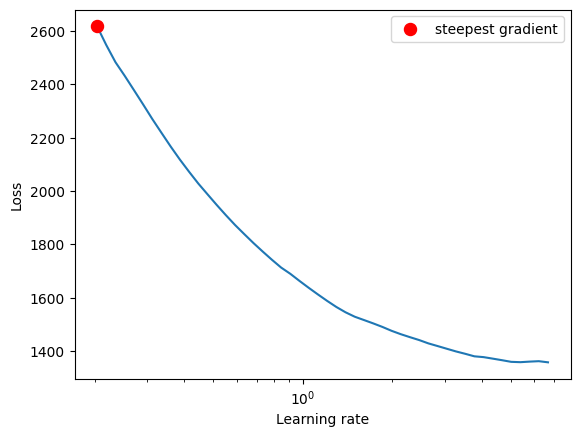

In [12]:
from torch_lr_finder import LRFinder

model =  ResNet18().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.1,weight_decay = 1e-4)
criterion = nn.CrossEntropyLoss(reduction='sum')
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, end_lr=100, num_iter=len(train_loader))
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset()

In [13]:
from torch.optim.lr_scheduler import OneCycleLR

model =  ResNet18().to(device)
optimizer = optim.Adam(model.parameters(), lr=8e-04,weight_decay = 1e-4)
scheduler = OneCycleLR(optimizer, max_lr=8e-02, steps_per_epoch=len(train_loader), epochs=20,div_factor=100,pct_start = 5/20)
criterion = nn.CrossEntropyLoss(reduction='sum')

EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer,scheduler,epoch,criterion)
    # scheduler.step()
    test(model, device, test_loader,criterion)

EPOCH: 0


Loss=506.1387634277344 Batch_id=97 Accuracy=39.10: 100%|██████████| 98/98 [00:42<00:00,  2.32it/s]



Test set: Average loss: 1.7911, Accuracy: 4273/10000 (42.73%)

EPOCH: 1


Loss=428.8173522949219 Batch_id=97 Accuracy=50.87: 100%|██████████| 98/98 [00:41<00:00,  2.38it/s]



Test set: Average loss: 1.8649, Accuracy: 4367/10000 (43.67%)

EPOCH: 2


Loss=370.85552978515625 Batch_id=97 Accuracy=60.54: 100%|██████████| 98/98 [00:41<00:00,  2.36it/s]



Test set: Average loss: 1.4097, Accuracy: 5486/10000 (54.86%)

EPOCH: 3


Loss=287.5118408203125 Batch_id=97 Accuracy=66.65: 100%|██████████| 98/98 [00:41<00:00,  2.36it/s]



Test set: Average loss: 0.9564, Accuracy: 6978/10000 (69.78%)

EPOCH: 4


Loss=253.47413635253906 Batch_id=97 Accuracy=71.71: 100%|██████████| 98/98 [00:41<00:00,  2.38it/s]



Test set: Average loss: 1.0310, Accuracy: 6613/10000 (66.13%)

EPOCH: 5


Loss=205.65203857421875 Batch_id=97 Accuracy=75.58: 100%|██████████| 98/98 [00:41<00:00,  2.37it/s]



Test set: Average loss: 0.6688, Accuracy: 7775/10000 (77.75%)

EPOCH: 6


Loss=201.89828491210938 Batch_id=97 Accuracy=78.40: 100%|██████████| 98/98 [00:41<00:00,  2.36it/s]



Test set: Average loss: 0.6446, Accuracy: 7866/10000 (78.66%)

EPOCH: 7


Loss=170.7211151123047 Batch_id=97 Accuracy=80.81: 100%|██████████| 98/98 [00:41<00:00,  2.37it/s]



Test set: Average loss: 0.5539, Accuracy: 8173/10000 (81.73%)

EPOCH: 8


Loss=179.6125946044922 Batch_id=97 Accuracy=82.86: 100%|██████████| 98/98 [00:41<00:00,  2.37it/s]



Test set: Average loss: 0.7978, Accuracy: 7560/10000 (75.60%)

EPOCH: 9


Loss=146.7431640625 Batch_id=97 Accuracy=84.08: 100%|██████████| 98/98 [00:41<00:00,  2.37it/s]



Test set: Average loss: 0.5284, Accuracy: 8268/10000 (82.68%)

EPOCH: 10


Loss=115.02276611328125 Batch_id=97 Accuracy=85.95: 100%|██████████| 98/98 [00:41<00:00,  2.38it/s]



Test set: Average loss: 0.3910, Accuracy: 8702/10000 (87.02%)

EPOCH: 11


Loss=116.8828125 Batch_id=97 Accuracy=87.41: 100%|██████████| 98/98 [00:41<00:00,  2.37it/s]



Test set: Average loss: 0.4388, Accuracy: 8604/10000 (86.04%)

EPOCH: 12


Loss=111.03123474121094 Batch_id=97 Accuracy=88.90: 100%|██████████| 98/98 [00:41<00:00,  2.38it/s]



Test set: Average loss: 0.3771, Accuracy: 8789/10000 (87.89%)

EPOCH: 13


Loss=73.40863800048828 Batch_id=97 Accuracy=90.67: 100%|██████████| 98/98 [00:41<00:00,  2.37it/s]



Test set: Average loss: 0.4456, Accuracy: 8675/10000 (86.75%)

EPOCH: 14


Loss=93.71858978271484 Batch_id=97 Accuracy=91.73: 100%|██████████| 98/98 [00:41<00:00,  2.35it/s]



Test set: Average loss: 0.3657, Accuracy: 8871/10000 (88.71%)

EPOCH: 15


Loss=91.96647644042969 Batch_id=97 Accuracy=93.05: 100%|██████████| 98/98 [00:41<00:00,  2.36it/s]



Test set: Average loss: 0.3159, Accuracy: 9056/10000 (90.56%)

EPOCH: 16


Loss=64.54023742675781 Batch_id=97 Accuracy=94.48: 100%|██████████| 98/98 [00:41<00:00,  2.38it/s]



Test set: Average loss: 0.3092, Accuracy: 9108/10000 (91.08%)

EPOCH: 17


Loss=47.034366607666016 Batch_id=97 Accuracy=95.18: 100%|██████████| 98/98 [00:41<00:00,  2.36it/s]



Test set: Average loss: 0.2988, Accuracy: 9134/10000 (91.34%)

EPOCH: 18


Loss=50.59125518798828 Batch_id=97 Accuracy=95.88: 100%|██████████| 98/98 [00:41<00:00,  2.37it/s]



Test set: Average loss: 0.2965, Accuracy: 9172/10000 (91.72%)

EPOCH: 19


Loss=43.25490951538086 Batch_id=97 Accuracy=95.95: 100%|██████████| 98/98 [00:41<00:00,  2.38it/s]



Test set: Average loss: 0.2955, Accuracy: 9183/10000 (91.83%)



Text(0.5, 1.0, 'Test Accuracy')

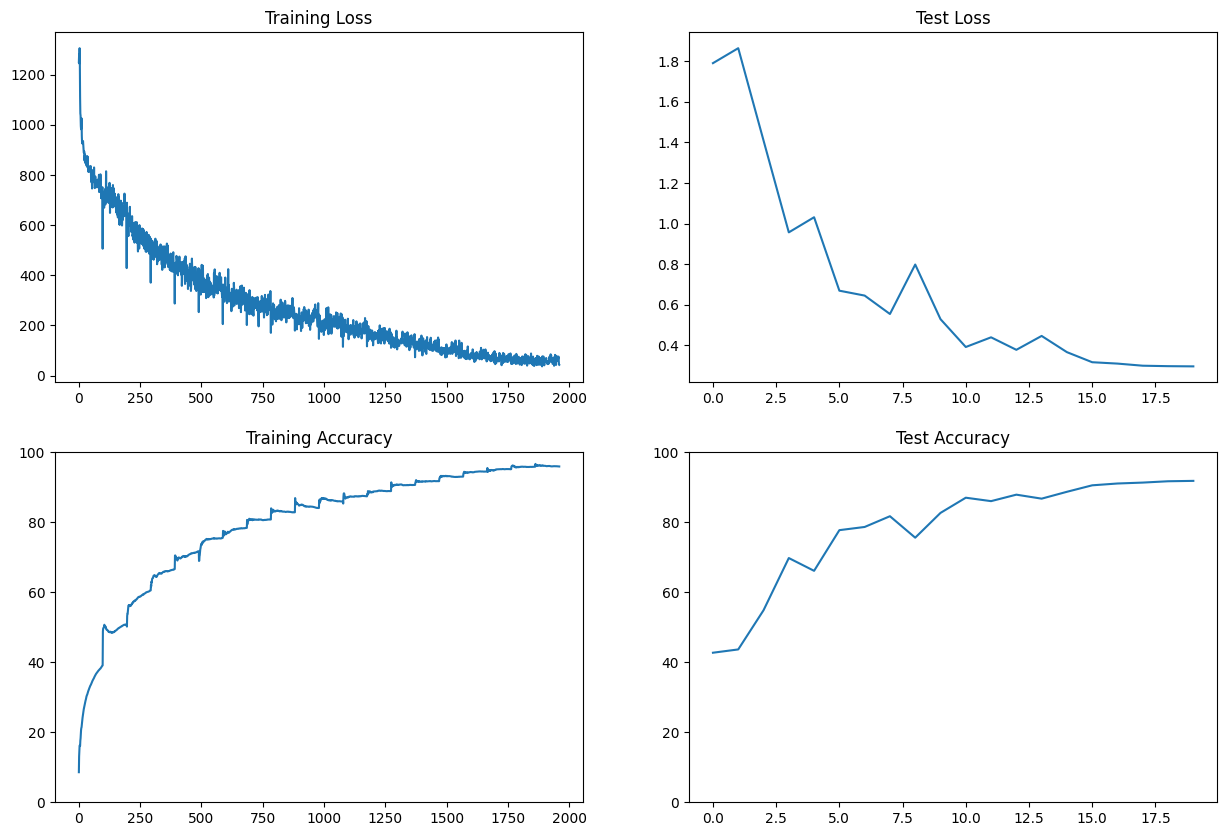

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot([x.cpu().item() for x in train_losses])
axs[0, 0].set_title("Training Loss")
axs[1,0].axis(ymin=0,ymax=100)
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1,1].axis(ymin=0,ymax=100)
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

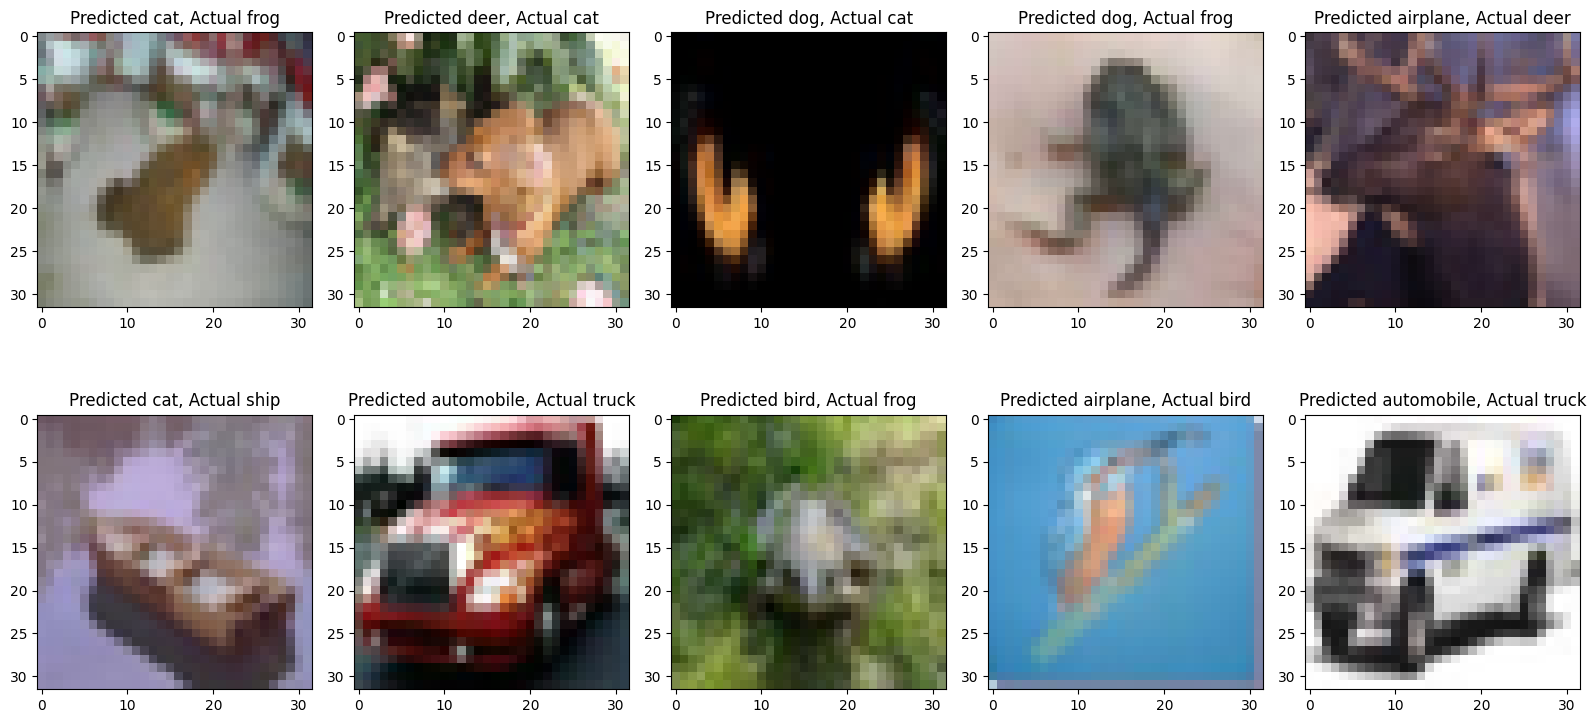

In [15]:
import matplotlib.pyplot as plt
import numpy as np

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

def get_incorrect_images(model,test_loader,n=10):
  incorrect_images = []
  predicted_labels = []
  correct_labels = []
  for data, target in test_loader:
    data, target = data.to(device), target.to(device)
    output = model(data)
    pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    incorrect_items = pred.ne(target.view_as(pred))
    incorrect_indices = incorrect_items.view(-1).nonzero().view(-1)
    predicted_labels.extend([item.item() for item in pred[incorrect_indices[:n-len(incorrect_images)]]])
    correct_labels.extend([item.item() for item in target.view_as(pred)[incorrect_indices[:n-len(incorrect_images)]]])
    incorrect_images.extend([item for item in data[incorrect_indices[:n-len(incorrect_images)]]])
    if len(incorrect_images)==n:
      break
  return incorrect_images,predicted_labels,correct_labels

def imshow(img):
  img = img / 2 + 0.5     # Unnormalize
  npimg = img
  npimg = np.clip(npimg, 0, 1)  # Add this line to clip the values
  return np.transpose(npimg, (1, 2, 0))  # Convert from Tensor image

fig, axes = plt.subplots(2, 5, figsize=(16, 8))

incorrect_images,predicted_labels,correct_labels = get_incorrect_images(model,test_loader,n=10)

for i, image_tensor in enumerate(incorrect_images):
    ax = axes[i // 5, i % 5]  # Get the location of the subplot
    image = image_tensor.cpu().numpy()
    ax.imshow(imshow(image))  # Display the image
    ax.set_title(f"Predicted {class_names[predicted_labels[i]]}, Actual {class_names[correct_labels[i]]}")  # Set the title as the index

plt.tight_layout()  # To provide sufficient spacing between subplots
plt.show()

In [16]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 24.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.4.8-py3-none-any.whl size=38247 sha256=aac58d29dd2370a11f31e14790eae601a45f20f7fc0c7d25055cac55fcbe49f1
  Stored in directory: /root/.cache/pip/wheels/f8/04/36/94ff3c8a4215826a21946b34c01180817e606989fdf53f7cd6
Successfully built grad-cam


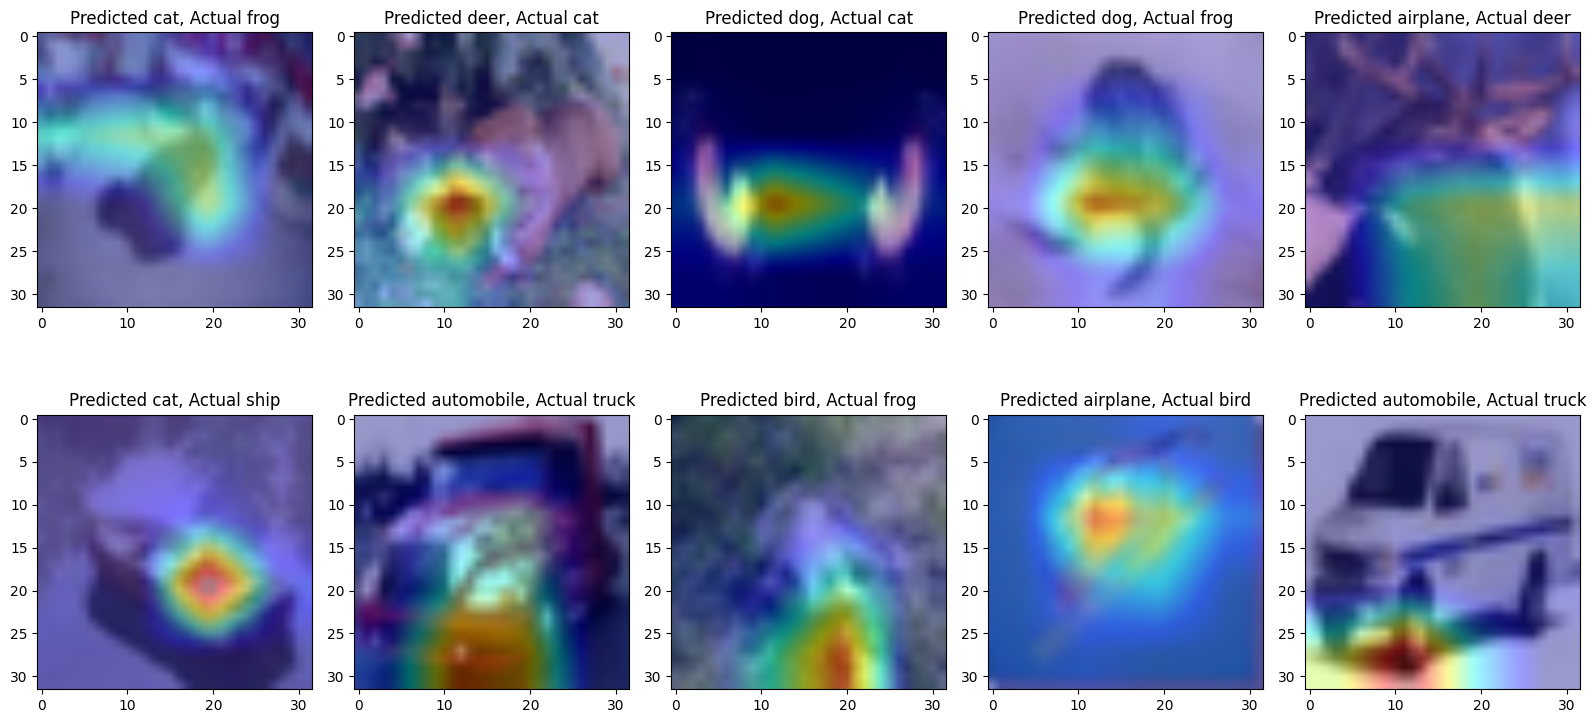

In [17]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

target_layers = [model.layer4[-1]]
cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)

fig, axes = plt.subplots(2, 5, figsize=(16, 8))

for i, image_tensor in enumerate(incorrect_images):
    ax = axes[i // 5, i % 5]  # Get the location of the subplot
    image = image_tensor.cpu().numpy()
    grayscale_cam = cam(input_tensor=image_tensor.reshape(1,3,32,32), targets=[ClassifierOutputTarget(predicted_labels[i])],aug_smooth=True,eigen_smooth=True)
    grayscale_cam = grayscale_cam[0, :]
    visualization = show_cam_on_image(imshow(image), grayscale_cam, use_rgb=True,image_weight=0.6)
    #ax.imshow(np.transpose(imshow(visualization), (2, 0, 1)))  # Display the image
    ax.imshow(visualization,interpolation='bilinear')
    ax.set_title(f"Predicted {class_names[predicted_labels[i]]}, Actual {class_names[correct_labels[i]]}")  # Set the title as the index

plt.tight_layout()  # To provide sufficient spacing between subplots
plt.show()